In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.metrics import *

import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1
import csv
from collections import defaultdict, namedtuple
import os
import shutil

import pandas as pd

from sklearn.metrics import confusion_matrix
from skimage import transform

/home/surajit_dey_airbus/anaconda3/envs/condaenv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
path = '../data/plant-seedlings'

# Exploratory analysis

In [3]:
arch=resnet34
sz = 224
bs = 64

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
data = ImageClassifierData.from_paths(path, tfms=tfms, test_name='test', bs=bs)

In [4]:
m = arch(True)
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [5]:
cam_model = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

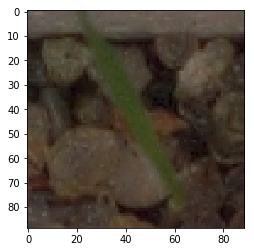

In [5]:
plt.imshow(load_img_id(data.val_ds, 10, path))
plt.show()

In [10]:
y = data.trn_ds.y

In [7]:
print(y[:10])

[0 0 0 0 0 0 0 0 0 0]


In [11]:
from collections import Counter

num_train = 0
label_counts = Counter(y).most_common()
for l, c in label_counts:
    num_train = num_train + c
    print(c, '\t', data.classes[l])
    
print(num_train)

524 	 Loose Silky-bent
489 	 Common Chickweed
413 	 Scentless Mayweed
397 	 Small-flowered Cranesbill
380 	 Fat Hen
312 	 Charlock
308 	 Sugar beet
230 	 Cleavers
211 	 Black-grass
185 	 Shepherds Purse
177 	 Common wheat
177 	 Maize
3803


Black-grass


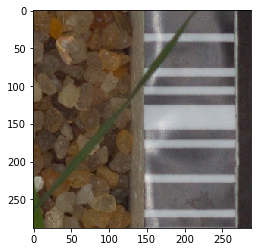

Charlock


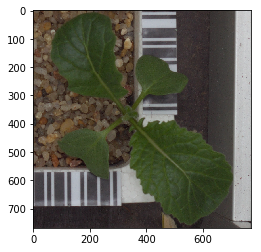

Cleavers


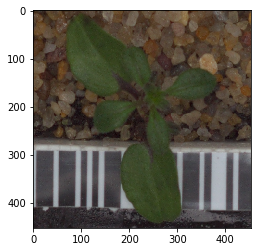

Common Chickweed


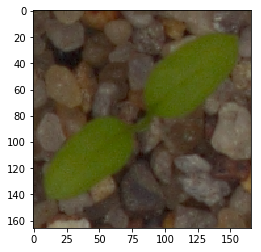

Common wheat


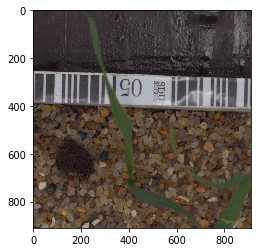

Fat Hen


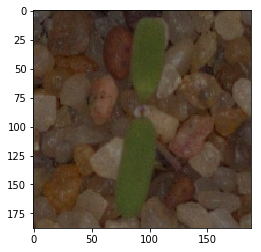

Loose Silky-bent


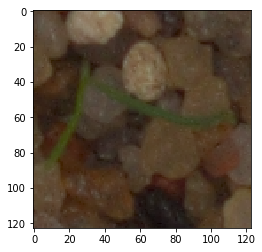

Maize


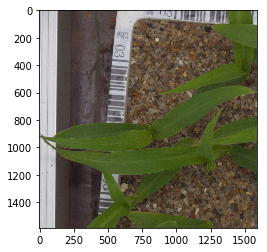

Scentless Mayweed


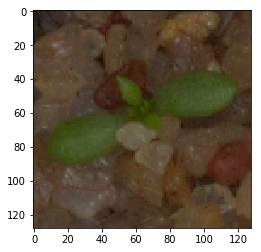

Shepherds Purse


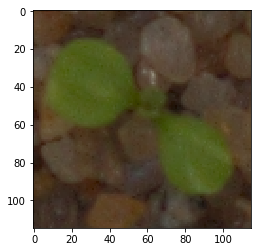

Small-flowered Cranesbill


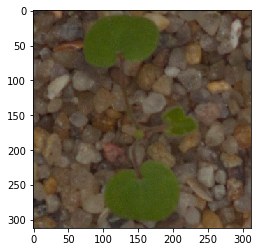

Sugar beet


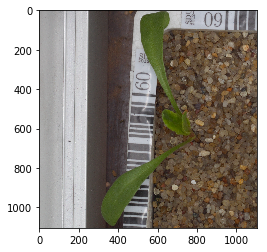

In [12]:
for label in sorted([l for l, c in label_counts], key=lambda p: data.classes[p]):
    i = [i for i, l in enumerate(y) if l == label][0]
    print(data.classes[y[i]])
    plt.imshow(load_img_id(data.trn_ds, i, path))
    plt.show()


train_df.shape =  (3803, 4)
test_df.shape =  (794, 2)


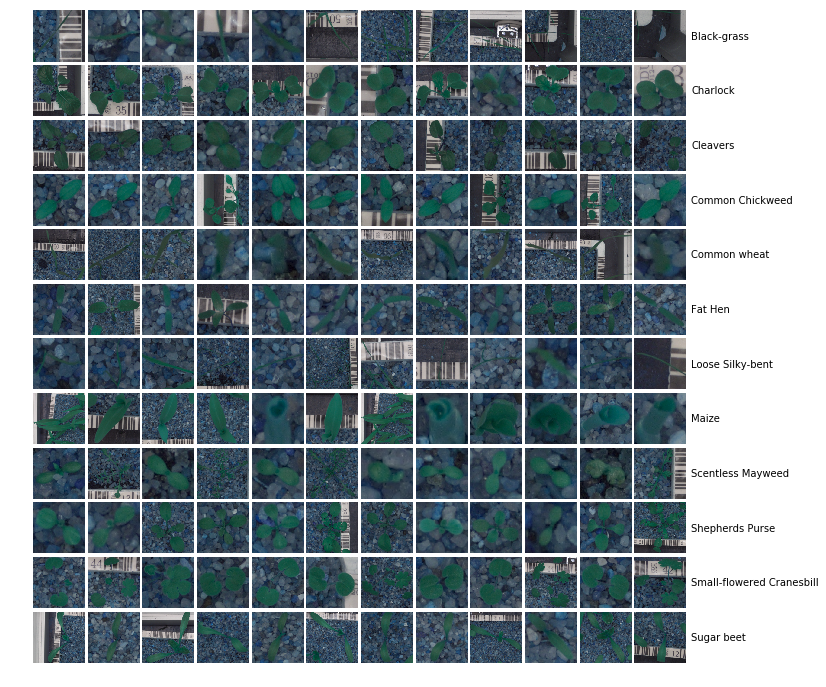

In [10]:
# function to read an image 
def read_image(filepath, target_size=None, img_resize=True):
    img = cv2.imread(os.path.join(path, filepath), cv2.IMREAD_COLOR)
    if img_resize:
        img = cv2.resize(img.copy(), target_size, interpolation = cv2.INTER_AREA)
    #img = image.load_img(os.path.join(data_dir, filepath),target_size=target_size)
    #img = image.img_to_array(img)
    return img

# read all train data
train_dir = os.path.join(path, 'train')
train = []
for species_id, sp in enumerate(data.classes):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train.append(['train/{}/{}'.format(sp, file), file, species_id, sp])
train_df = pd.DataFrame(train, columns=['filepath', 'file', 'species_id', 'species'])
print('')
print('train_df.shape = ', train_df.shape)

# read all test data
test_dir = os.path.join(path, 'test')
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test_df = pd.DataFrame(test, columns=['filepath', 'file'])
print('test_df.shape = ', test_df.shape)

num_species = len(data.classes)
show_plots = True

## show 12 images of all species of train data
if show_plots:
    fig = plt.figure(1, figsize=(num_species, num_species))
    grid = mpl_toolkits.axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_species, num_species), 
                                             axes_pad=0.05)
    i = 0
    for species_id, sp in enumerate(data.classes):
        for filepath in train_df[train_df['species'] == sp]['filepath'].values[:num_species]:
            ax = grid[i]
            img = read_image(filepath, (224, 224))
            ax.imshow(img.astype(np.uint8))
            ax.axis('off')
            if i % num_species == num_species - 1:
                ax.text(250, 112, sp, verticalalignment='center')
            i += 1
    plt.show();

In [11]:
## get all image shapes: this is time-consuming, therefore I have deactivated
## the code. The results are included below and show that all
## images are quadratic, but their size can be very different. 

if True:
    train_df['image_heigth'] = 0
    train_df['image_width'] = 0
    train_df['image_channel'] = 0

    #get all image shapes
    for i in range(len(train_df)):
        img = read_image(train_df.filepath.values[i], img_resize=False)
        train_df.loc[i,'image_heigth'] = img.shape[0]
        train_df.loc[i,'image_width'] = img.shape[1]
        train_df.loc[i,'image_channel'] = img.shape[2]

    test_df['image_heigth'] = 0
    test_df['image_width'] = 0
    test_df['image_channel'] = 0

    # get all image shapes
    for i in range(len(test_df)):
        img = read_image(test_df.filepath.values[i], img_resize=False)
        test_df.loc[i,'image_heigth'] = img.shape[0]
        test_df.loc[i,'image_width'] = img.shape[1]
        test_df.loc[i,'image_channel'] = img.shape[2]

In [12]:
# train data
print(train_df.describe())
train_df.head()

        species_id  image_heigth  image_width  image_channel
count  3803.000000   3803.000000  3803.000000         3803.0
mean      5.668420    370.895346   371.815146            3.0
std       3.311501    321.973843   327.688773            0.0
min       0.000000     49.000000    49.000000            3.0
25%       3.000000    140.000000   140.000000            3.0
50%       6.000000    265.000000   265.000000            3.0
75%       8.000000    505.000000   505.000000            3.0
max      11.000000   3457.000000  3991.000000            3.0


filepath           file  species_id      species  \
0  train/Black-grass/279ac215b.png  279ac215b.png           0  Black-grass   
1  train/Black-grass/70bfa70ff.png  70bfa70ff.png           0  Black-grass   
2  train/Black-grass/fab809601.png  fab809601.png           0  Black-grass   
3  train/Black-grass/173cec485.png  173cec485.png           0  Black-grass   
4  train/Black-grass/3ff68fa8a.png  3ff68fa8a.png           0  Black-grass   

   image_heigth  image_width  image_channel  
0           288          288              3  
1           113          113              3  
2            91           91              3  
3           110          110              3  
4           107          107              3

## Image sizes

In [13]:
flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR

folder = path + '/all/Black-grass'

files = os.listdir(folder)
sizes = []

for file in files:
    filename = os.path.join(folder, file)
    img = cv2.imread(filename, flags)
    sizes.append(max(img.shape[0], img.shape[1]))

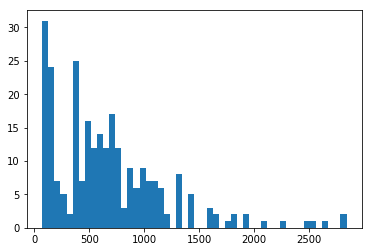

In [14]:
plt.hist(sizes, bins=50)
plt.show()

# Image lighting

Let's try histogram equalization to improve constrast.

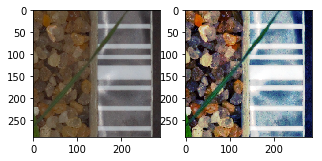

(288, 288, 3)


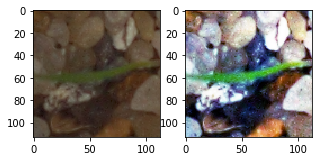

(113, 113, 3)


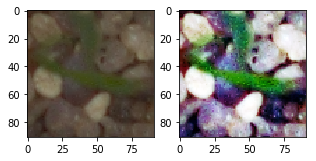

(91, 91, 3)


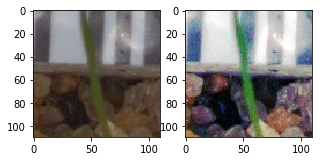

(110, 110, 3)


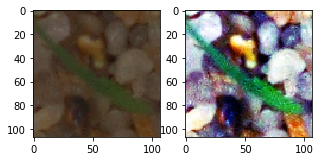

(107, 107, 3)


In [15]:
flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR

folder = path + '/all/Black-grass'

files = os.listdir(folder)
for i in range(5):
    f = plt.figure(figsize=(5, 5))
    
    filename = os.path.join(folder, files[i])
    img = cv2.imread(filename, flags)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    sp = f.add_subplot(1, 2, 1)
    plt.imshow(img)
    
    img = np.concatenate([np.expand_dims(cv2.equalizeHist(img[:,:,i]), axis=2) for i in range(3)], axis=2)
    
    
    sp = f.add_subplot(1, 2, 2)
    plt.imshow(img)
    plt.show()
    
    print(img.shape)

In [52]:
# Normal version

def open_image_normal(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The numpy array representation of the image in the RGB format
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            return cv2.cvtColor(cv2.imread(fn, flags), cv2.COLOR_BGR2RGB).astype(np.float32)/255
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [53]:
# Histogram equalization

def open_image_hist_eq(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The numpy array representation of the image in the RGB format
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            img = cv2.cvtColor(cv2.imread(fn, flags), cv2.COLOR_BGR2RGB)
            img = np.concatenate([np.expand_dims(cv2.equalizeHist(img[:,:,i]), axis=2) for i in range(3)], axis=2)
            return img.astype(np.float32)/255
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

Uncomment the 2nd line below to apply histogram equalization to fastai dataset code.

In [54]:
#open_image = open_image_normal
#open_image = open_image_hist_eq

# Image augmentation

Here we can change image augmentation parameters and see how augmented images look like.

In [6]:
# Look at examples of image augmentation
def get_augs():
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

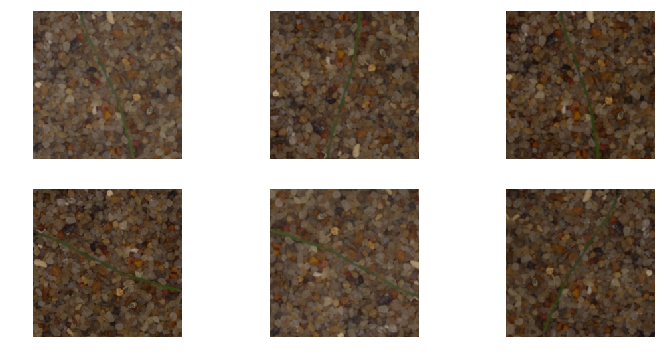

In [7]:
bs = 64

#aug_tfms = [RandomRotate(20), RandomLighting(0.8, 0.8)]
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
data = ImageClassifierData.from_paths(path, tfms=tfms, test_name='test', bs=bs)

ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

# Training

In [8]:
# Create a learner
#learn = ConvLearner.pretrained(arch, data, precompute=False)
cam_model = to_gpu(cam_model)
learn = ConvLearner.from_model_data(cam_model, data)

In [9]:
wd=5e-4

In [10]:
learn.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

In [11]:
learn.freeze_to(-4)

In [12]:
learn.fit(1e-2, 1, cycle_len=1)

  0%|          | 0/60 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1535491974311/work/aten/src/THC/generic/THCStorage.cpp:36

## Searching for a good starting learning rate

In [15]:
def plot_loss_change(sched, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
    """
    Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(learn.sched.lrs)):
        derivative = (learn.sched.losses[i] - learn.sched.losses[i - sma]) / sma
        derivatives.append(derivative)
        
    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(learn.sched.lrs[n_skip:], derivatives[n_skip:])
    plt.xscale('log')
    plt.ylim(y_lim)

In [16]:
learn.lr_find()

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1535491974311/work/torch/csrc/generic/serialization.cpp:17

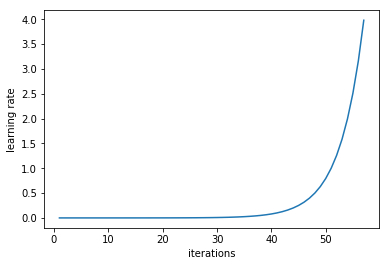

In [22]:
learn.sched.plot_lr()

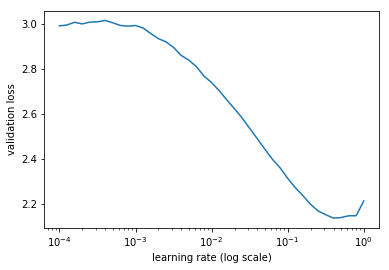

In [23]:
learn.sched.plot()

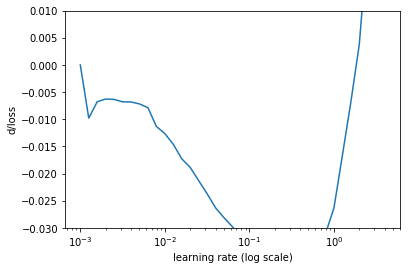

In [24]:
plot_loss_change(learn.sched, sma=20, n_skip=20, y_lim=(-0.03, 0.01))

## Training with LR 0.01 for 1 epoch

In [11]:
learn.fit(0.01, 20, wds=wd)

  0%|          | 0/60 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1535491974311/work/aten/src/THC/generic/THCTensorMath.cu:26

In [26]:
learn.save('step1')

In [27]:
learn.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), 

In [28]:
learn.fit(0.01, 2, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.31889    0.283451   0.907075  
    1      0.333989   0.289306   0.898627                  
    2      0.289608   0.283926   0.900739                  


[0.2839258639525461, 0.9007391766610594]

In [30]:
learn.save('step1_cycle')

In [17]:
learn.load('step1_cycle')

In [18]:
learn.unfreeze()
learn.lr_find()

 92%|█████████▏| 55/60 [00:28<00:01,  2.57it/s, loss=3.41] 

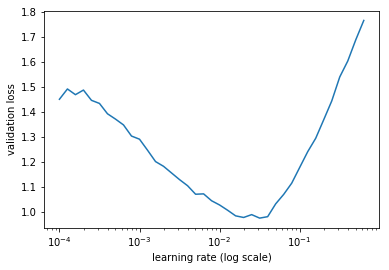

In [19]:
learn.sched.plot()

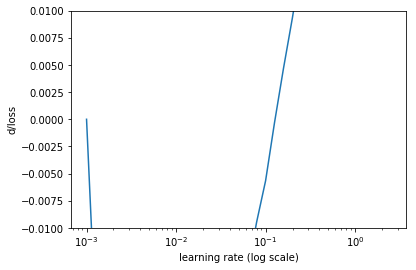

In [22]:
plot_loss_change(learn.sched, sma=20, n_skip=20, y_lim=(-0.01, 0.01))

## Unfreeze and train with LR 0.01 for 3 epochs

In [54]:
learn.load('unfreeze1')

In [ ]:
learn.unfreeze()

In [26]:
learn.fit(1e-3, 5, wds=wd)
#learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy                  
    0      0.133811   0.132977   0.956705  


[0.1329767244387076, 0.9567053887005719]

In [27]:
learn.save('unfreeze1')

In [28]:
learn.lr_find()

 68%|██████▊   | 41/60 [00:22<00:08,  2.24it/s, loss=0.474]

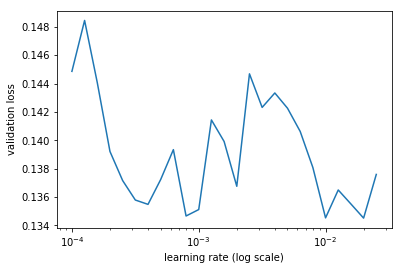

In [29]:
learn.sched.plot()

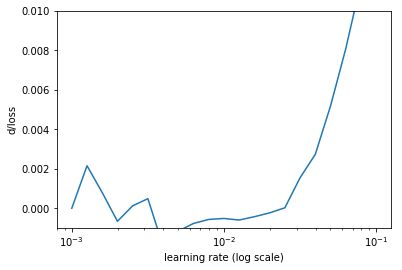

In [30]:
plot_loss_change(learn.sched, sma=20, n_skip=20, y_lim=(-0.001, 0.01))

## Train for a few cycles

In [59]:
learn.load('unfreeze1')

In [32]:
lr=1e-3

In [33]:
learn.fit(lr, 1, cycle_len=1, cycle_mult=2, wds=wd)
#learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.111093   0.124417   0.954593  


[0.12441675312946912, 0.9545934530095037]

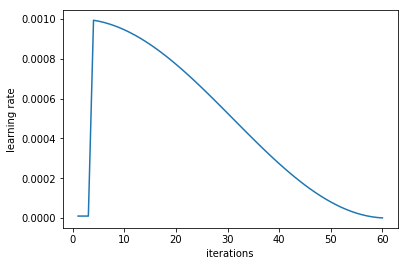

In [36]:
learn.sched.plot_lr()

In [37]:
learn.save('2')

In [85]:
learn.load('2')

In [81]:
learn.lr_find()

 90%|█████████ | 113/125 [00:37<00:03,  3.55it/s, loss=1.99]

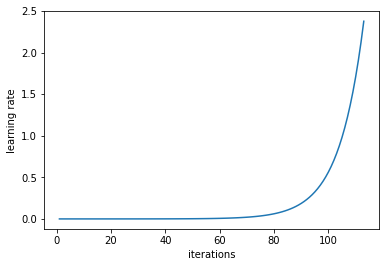

In [82]:
learn.sched.plot_lr()

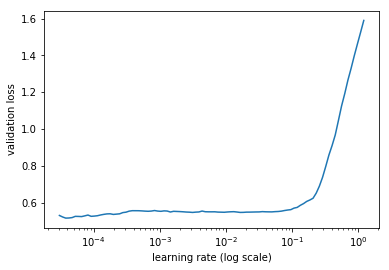

In [83]:
learn.sched.plot()

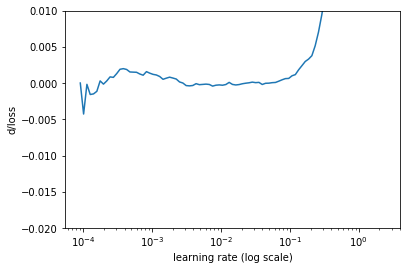

In [84]:
plot_loss_change(learn.sched, sma=20, n_skip=20, y_lim=(-0.02, 0.01))

## Class Activation Maps (CAM)

In [4]:
arch=resnet34
sz = 224
bs = 64
m = arch(True)
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [5]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(2048, 2, 1, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [6]:
m

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [7]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
data = ImageClassifierData.from_paths(path, tfms=tfms, test_name='test', bs=bs)

In [9]:
# Create a learner
learn = ConvLearner.pretrained(arch, data, precompute=False)
#learn.load('unfreeze1')
learn.unfreeze

<bound method ConvLearner.unfreeze of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpl

In [11]:
learn.fit(0.01, 5, wds=5e-4)

epoch      trn_loss   val_loss   accuracy                  
    0      1.557335   0.96228    0.67265   
    1      1.171675   0.747385   0.756072                  
    2      0.985735   0.730079   0.757128                  
    3      0.876711   0.635054   0.785639                  
    4      0.835398   0.601276   0.795143                  



[0.6012759591357383, 0.7951425558158689]

In [12]:
learn.save("unfreeze_temp")

In [11]:
# Get the model
cam_model = learn.model
# This class will be used to save the features
class SaveFeatures:
    def __init__(self, m):
        self.handle = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, m, inp, outp):
        self.features = outp
    def remove(self):
        self.handle.remove()

# Save the features of the layer 8, the convolution we have added
sf = [SaveFeatures(ml) for ml in [cam_model[8]]]

In [12]:
# Get the input data, the prediction, and the CAM areas for a batch size in the training set
# and display them
def show_CAM(model, images, classes):
    # Make the prediction on the batch
    log_prob = model(to_gpu(V(images)))
    # Denormalize the input of the batch
    x1 = data.val_ds.denorm(images)
    f = plt.figure(figsize=(16,8))
    rows=2
    for idx in range(len(x1)):
        # Get the activation of one image
        fts = sf[0].features[idx]
        prob = np.exp(to_np(log_prob))
        preds = np.argmax(prob[idx])
        fts_np = to_np(fts)
        f2=np.dot(np.rollaxis(fts_np,0,3), prob[idx])
        f2-=f2.min()
        f2/=f2.max()
        f2
        sp = f.add_subplot(rows, len(x1)//rows, idx+1)
        sp.axis('Off')
        sp.set_title(classes[preds], fontsize=12)
        plt.imshow(x1[idx])
        plt.imshow(scipy.misc.imresize(f2, x1[idx].shape), alpha=0.5, cmap='jet');
        #plt.imshow(skt.resize(f2, x1[idx].shape), alpha=0.5, cmap='hot');
    plt.show();

In [20]:
# We ask to display the image of the first 4 batches
for i in range(4):
    x, y = next(iter(data.trn_dl))
    print(x.shape)
    print(y.shape)
    #x = x[None, None, 1]
    show_CAM(cam_model, x, data.classes)

torch.Size([64, 3, 224, 224])
torch.Size([64])


ValueError: shapes (1,1,4096) and (12,) not aligned: 4096 (dim 2) != 12 (dim 0)

<Figure size 1152x576 with 0 Axes>

In [13]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [14]:
x,y = next(iter(data.val_dl))

In [15]:
x,y = x[None,1], y[None,1]
vx = Variable(x.cuda(), requires_grad=True)

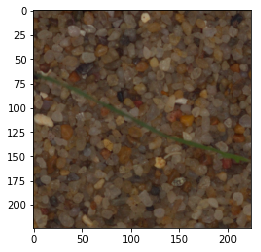

In [16]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [17]:
m[-4]

Conv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))

In [18]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [22]:
%time py = m(Variable(x.cuda()))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
for o in sfs: o.remove()

In [ ]:
[o.features.size() for o in sfs]

In [ ]:
py = np.exp(to_np(py)[0]); py

In [ ]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

In [ ]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

In [ ]:
plt.imshow(dx)
plt.imshow(transform.resize(f2, dx.shape), alpha=0.5, cmap='hot');

## Error analysis

In [68]:
log_preds,y = learn.predict_with_targs()
preds = np.exp(log_preds)
pred_labels = np.argmax(preds, axis=1)

[[ 39   0   0   0   1   0  12   0   0   0   0   0]
 [  0  77   1   0   0   0   0   0   0   0   0   0]
 [  0   0  57   0   0   0   0   0   0   0   0   0]
 [  0   0   0 122   0   0   0   0   0   0   0   0]
 [  0   0   0   0  43   1   0   0   0   0   0   0]
 [  1   0   0   0   0  94   0   0   0   0   0   0]
 [  4   0   0   0   0   0 125   0   1   0   0   0]
 [  0   0   0   0   0   0   0  43   1   0   0   0]
 [  0   0   0   0   0   0   0   0 103   0   0   0]
 [  0   0   0   0   0   0   0   0   1  45   0   0]
 [  0   0   0   0   0   0   0   0   0   0  99   0]
 [  0   0   0   0   1   0   0   0   0   0   0  76]]


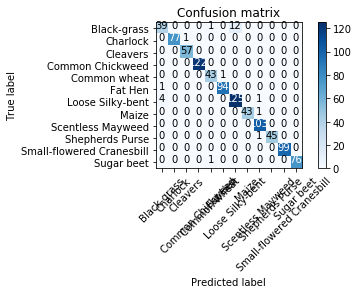

In [72]:
cm = confusion_matrix(y, pred_labels)
plot_confusion_matrix(cm, data.classes)

In [73]:
results = ImageModelResults(data.val_ds, log_preds)

### Most incorrect

In [75]:
incorrect = [i for i in range(len(pred_labels)) if pred_labels[i] != y[i]]
c = Counter([(y[i], data.classes[y[i]]) for i in incorrect])
c.most_common(20)

[((0, 'Black-grass'), 13),
 ((6, 'Loose Silky-bent'), 5),
 ((1, 'Charlock'), 1),
 ((4, 'Common wheat'), 1),
 ((5, 'Fat Hen'), 1),
 ((7, 'Maize'), 1),
 ((9, 'Shepherds Purse'), 1),
 ((11, 'Sugar beet'), 1)]

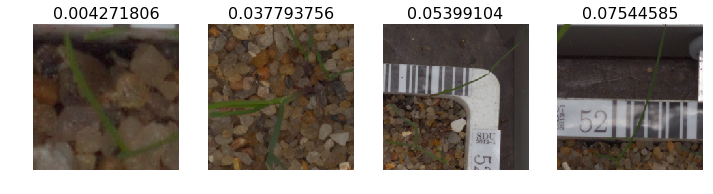

In [82]:
results.plot_most_incorrect(0)

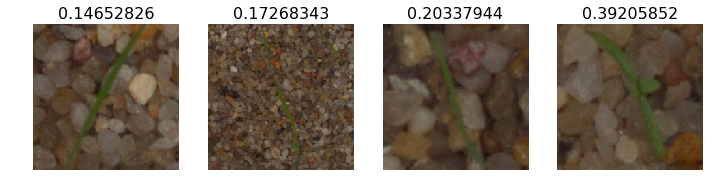

In [83]:
results.plot_most_incorrect(6)

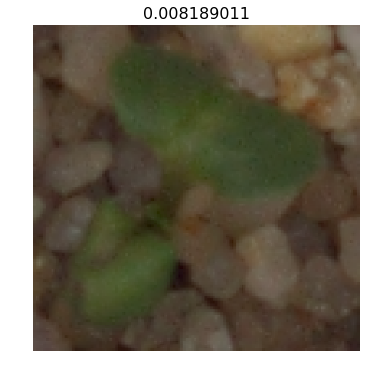

In [84]:
results.plot_most_incorrect(1)

### Most correct

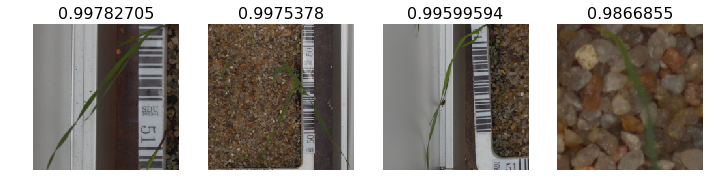

In [85]:
results.plot_most_correct(0)

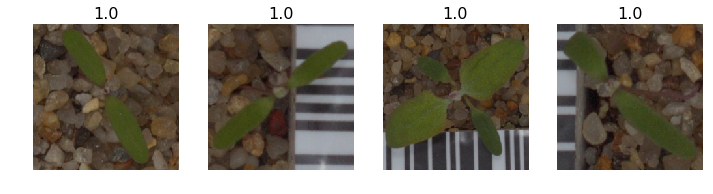

In [86]:
results.plot_most_correct(5)

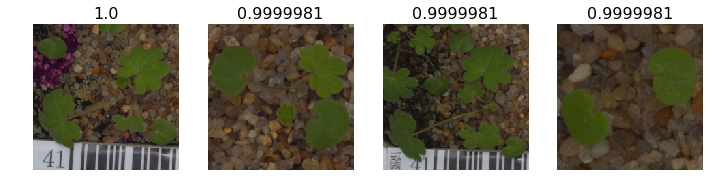

In [87]:
results.plot_most_correct(10)

### Most uncertain

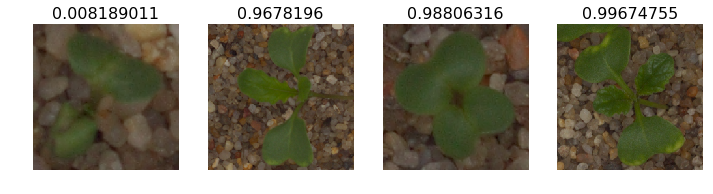

In [88]:
results.plot_most_uncertain(1)

## Test time augmentation (TTA)

In [89]:
log_preds,y = learn.TTA(n_aug=20)
preds = np.mean(np.exp(log_preds),0)

In [90]:
accuracy_np(preds, y)

0.9736008447729673

# Retrain on the training set + validation set

Validation loss/accuracy won't be indicative of the model performance because the validation set is a subset of the training set now.

In [91]:
arch = resnet50
sz = 224
bs = 64
wd = 5e-4

In [92]:
#aug_tfms = [RandomRotate(20), RandomLighting(0.8, 0.8)]
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
data = ImageClassifierData.from_paths(path, tfms=tfms, trn_name='all', val_name='valid', test_name='test', bs=bs)

In [93]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [50]:
lr = 0.01

In [98]:
learn.fit(lr, 10, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.465356   0.261811   0.914467  
    1      0.434695   0.266085   0.918691                  
    2      0.444596   0.257631   0.914467                  
    3      0.445648   0.260946   0.913411                  
    4      0.425497   0.259499   0.918691                  
    5      0.439303   0.256931   0.916579                  
    6      0.419498   0.25027    0.92397                   
    7      0.407108   0.247527   0.920803                  
    8      0.415879   0.244579   0.928194                  
    9      0.43067    0.240105   0.920803                  


[0.24010528414780638, 0.9208025346336043]

In [99]:
learn.save('step1_full')

In [ ]:
learn.load('step1_full')

In [105]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.383124   0.228693   0.927138  
    1      0.386057   0.22698    0.930306                  
    2      0.388043   0.227511   0.928194                  
    3      0.376888   0.229764   0.927138                  
    4      0.390631   0.220021   0.93453                   
    5      0.383395   0.220832   0.931362                  
    6      0.390315   0.220105   0.933474                  
    7      0.38625    0.222051   0.92925                   
    8      0.381458   0.221395   0.92925                   
    9      0.386564   0.216554   0.927138                  
    10     0.385234   0.217357   0.932418                  
    11     0.393986   0.220177   0.927138                  
    12     0.364112   0.218086   0.927138                  
    13     0.382368   0.213131   0.92925                   
    14     0.386343   0.218862   0.925026                  
 25%|██▌       | 19/75 [00:10<00:25,  2.22it/s, loss=0.3

KeyboardInterrupt: 

In [103]:
learn.save('step1_cycle_full')

In [106]:
learn.load('step1_cycle_full')

In [119]:
learn.load('final_full')

In [127]:
learn.unfreeze()
learn.fit(1e-3, 1, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      0.044835   0.016918   0.992608  


[0.01691799756993147, 0.9926082365364308]

In [125]:
learn.save('final_full')

In [126]:
learn.save('final_full_val013_997')

In [138]:
learn.load('final_full_val013_997')

In [173]:
learn.load('final_full_cycle')

In [181]:
learn.fit(1e-3, 1, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      0.035868   0.008731   0.998944  


[0.008731213128813784, 0.9989440337909187]

In [182]:
learn.save('final_full_cycle')

In [183]:
log_preds, y = learn.TTA(n_aug=20) # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9989440337909187, 0.010260744943123762)

In [184]:
preds = np.argmax(probs, axis=1)
print(probs.shape)
print(preds)
print(preds.shape)

(947, 12)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4

[[ 51   0   0   0   0   0   1   0   0   0   0   0]
 [  0  78   0   0   0   0   0   0   0   0   0   0]
 [  0   0  57   0   0   0   0   0   0   0   0   0]
 [  0   0   0 122   0   0   0   0   0   0   0   0]
 [  0   0   0   0  44   0   0   0   0   0   0   0]
 [  0   0   0   0   0  95   0   0   0   0   0   0]
 [  0   0   0   0   0   0 130   0   0   0   0   0]
 [  0   0   0   0   0   0   0  44   0   0   0   0]
 [  0   0   0   0   0   0   0   0 103   0   0   0]
 [  0   0   0   0   0   0   0   0   0  46   0   0]
 [  0   0   0   0   0   0   0   0   0   0  99   0]
 [  0   0   0   0   0   0   0   0   0   0   0  77]]


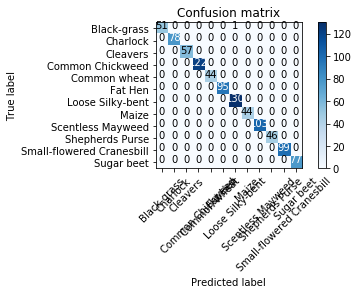

In [185]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [186]:
test_log_predictions, _ = learn.TTA(is_test=True)
test_probs = np.mean(np.exp(test_log_predictions),0)
test_predictions = np.argmax(test_probs, axis=1)
print(test_predictions.shape)
test_predictions_classes = [data.classes[pred] for pred in test_predictions]
test_file_names = learn.data.test_ds.fnames

with open('submission.csv', 'w') as the_file:
    the_file.write('file,species\n')
    for file_path, prediction in zip(test_file_names, test_predictions_classes):
        file_name = file_path.split('/')[-1]
        the_file.write(file_name)
        the_file.write(",")
        the_file.write(prediction)
        the_file.write("\n")
the_file.close()

from IPython.display import FileLink
FileLink('submission.csv')

(794,)                                       


/home/surajit_dey_airbus/Notebooks/GTSRB/submission.csv

In [190]:
from collections import Counter

def winner(input): 
  
     # convert list of candidates into dictionary 
     # output will be likes candidates = {'A':2, 'B':4} 
     votes = Counter(input)
     #print(votes)
       
     # create another dictionary and it's key will 
     # be count of votes values will be name of  
     # candidates 
     dict = {} 
  
     for value in votes.values(): 
  
          # initialize empty list to each key to  
          # insert candidate names having same  
          # number of votes  
          dict[value] = [] 
  
     for (key,value) in votes.items(): 
          dict[value].append(key) 
  
     # sort keys in descending order to get maximum  
     # value of votes 
     maxVote = sorted(dict.keys(),reverse=True)[0] 
  
     # check if more than 1 candidates have same  
     # number of votes. If yes, then sort the list 
     # first and print first element 
     if len(dict[maxVote])>1:
         return sorted(dict[maxVote])[0]
     else:
         return dict[maxVote][0]

In [196]:
import pandas as pd

submission1 = './submission23.csv'
submission2 = './submission22.csv'
submission3 = './submission21.csv'
submission4 = './submission18.csv'
submission5 = './submission17.csv'
submission6 = './submission17.csv'
submission7 = './submission16.csv'

counter = 0

df1 = pd.read_csv(submission1)
df2 = pd.read_csv(submission2)
df3 = pd.read_csv(submission3)
df4 = pd.read_csv(submission4)
df5 = pd.read_csv(submission5)
df6 = pd.read_csv(submission6)
df7 = pd.read_csv(submission7)

classes = []
speciesList = []

for i in range(0, len(df1)):
    classes.append(winner([df1['species'][i], df2['species'][i], df3['species'][i], df4['species'][i], df5['species'][i], df6['species'][i], df7['species'][i]]))

with open('submission.csv', 'w') as the_file:
    the_file.write('file,species\n')
    for file_path, prediction in zip(test_file_names, classes):
        file_name = file_path.split('/')[-1]
        the_file.write(file_name)
        the_file.write(",")
        the_file.write(prediction)
        the_file.write("\n")
the_file.close()

from IPython.display import FileLink
FileLink('submission.csv')

/home/surajit_dey_airbus/Notebooks/GTSRB/submission.csv

In [17]:
learn.data.test_ds.fnames

['test/0021e90e4.png',
 'test/003d61042.png',
 'test/007b3da8b.png',
 'test/0086a6340.png',
 'test/00c47e980.png',
 'test/00d090cde.png',
 'test/00ef713a8.png',
 'test/01291174f.png',
 'test/026716f9b.png',
 'test/02cfeb38d.png',
 'test/03566743d.png',
 'test/03a2ee656.png',
 'test/03e322a29.png',
 'test/03ef36742.png',
 'test/043449b0b.png',
 'test/0437393b1.png',
 'test/04814f36d.png',
 'test/05341a8a6.png',
 'test/060450d79.png',
 'test/060f1dc84.png',
 'test/0625f063b.png',
 'test/063363305.png',
 'test/06d12f6fa.png',
 'test/071cb3ece.png',
 'test/0751c0bbc.png',
 'test/07e62f903.png',
 'test/085974290.png',
 'test/0885e7690.png',
 'test/089ad62a7.png',
 'test/08d591441.png',
 'test/0911d3dee.png',
 'test/099b961ec.png',
 'test/0a64e3e6c.png',
 'test/0ad9e7dfb.png',
 'test/0ae6668fa.png',
 'test/0bf7bfb05.png',
 'test/0c27cf05f.png',
 'test/0c4199daa.png',
 'test/0c45ace27.png',
 'test/0c51bf229.png',
 'test/0c5f6c493.png',
 'test/0caeda5df.png',
 'test/0d117d910.png',
 'test/0d31

# Testing on the test set

In [18]:
true_test_labels = {a.filename: a.label for a in test_annotations}
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(true_test_labels[filename]) for filename in filenames]
y_true = np.array([class_indexes[label] for label in labels])

NameError: name 'test_annotations' is not defined

In [2687]:
log_preds = learn.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.9929532858273951

In [2688]:
log_preds,_ = learn.TTA(n_aug=20, is_test=True)
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds, y_true)

0.9961203483768805

# Analyze test results

In [2689]:
pred_labels = np.argmax(preds, axis=1)

In [2690]:
incorrect = [i for i in range(len(pred_labels)) if pred_labels[i] != y_true[i]]

Road work Double curve 0.034049597 0.28313398


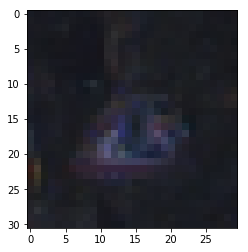

General caution Traffic signals 0.055051826 0.38334128


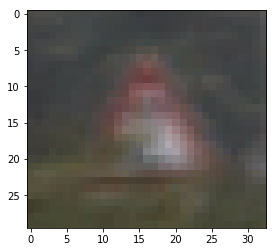

Speed limit (70km/h) Speed limit (30km/h) 0.33729976 0.44535047


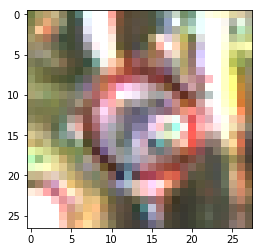

Speed limit (60km/h) Speed limit (80km/h) 0.29399717 0.54352564


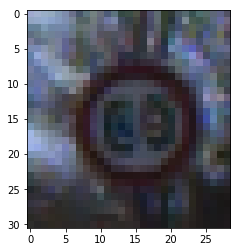

No entry Stop 0.26902562 0.5212469


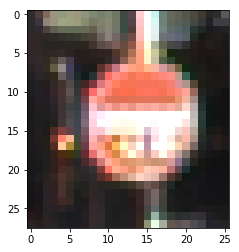

Right-of-way at the next intersection Beware of ice/snow 0.4352147 0.4685582


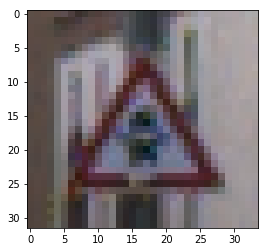

Roundabout mandatory Go straight or left 0.06904172 0.50923705


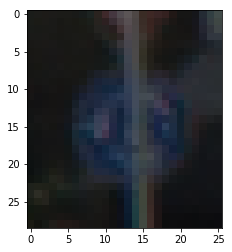

General caution Traffic signals 0.43430412 0.4459024


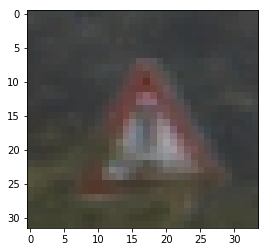

Right-of-way at the next intersection Beware of ice/snow 0.21131893 0.6463649


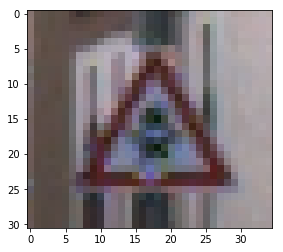

No entry Stop 0.20333719 0.5997053


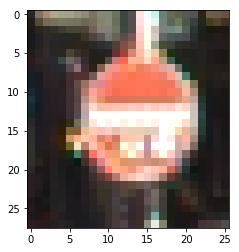

In [2691]:
for i in range(0,10):
    print(class_names[data.classes[y_true[incorrect[i]]]], class_names[data.classes[pred_labels[incorrect[i]]]], 
          preds[incorrect[i], y_true[incorrect[i]]], preds[incorrect[i], pred_labels[incorrect[i]]])
    plt.imshow(load_img_id(data.test_ds, incorrect[i], path))
    plt.show()

In [2692]:
cm = confusion_matrix(y_true, pred_labels)

In [2693]:
np.savetxt(os.path.join(path, 'confusion_matrix.tsv'), cm, delimiter='\t')

In [2694]:
c = Counter([class_names[data.classes[y_true[i]]] for i in incorrect])
c.most_common(20)

[('Speed limit (60km/h)', 7),
 ('General caution', 6),
 ('Road work', 5),
 ('Speed limit (70km/h)', 5),
 ('No entry', 5),
 ('Beware of ice/snow', 4),
 ('Roundabout mandatory', 3),
 ('End of speed limit (80km/h)', 3),
 ('Right-of-way at the next intersection', 2),
 ('Yield', 2),
 ('No vechiles', 1),
 ('Speed limit (120km/h)', 1),
 ('Speed limit (100km/h)', 1),
 ('No passing for vechiles over 3.5 metric tons', 1),
 ('Go straight or right', 1),
 ('Road narrows on the right', 1),
 ('Speed limit (50km/h)', 1)]

In [2695]:
c = Counter([class_names[data.classes[pred_labels[i]]] for i in incorrect])
c.most_common(20)

[('Speed limit (80km/h)', 8),
 ('Stop', 5),
 ('Speed limit (70km/h)', 5),
 ('Dangerous curve to the left', 4),
 ('Right-of-way at the next intersection', 4),
 ('Double curve', 3),
 ('Traffic signals', 3),
 ('Speed limit (50km/h)', 3),
 ('Speed limit (30km/h)', 2),
 ('Beware of ice/snow', 2),
 ('Priority road', 2),
 ('Go straight or left', 1),
 ('Speed limit (120km/h)', 1),
 ('Speed limit (100km/h)', 1),
 ('Keep right', 1),
 ('General caution', 1),
 ('Road work', 1),
 ('Ahead only', 1),
 ('Go straight or right', 1)]

# Create a submission file

In [2696]:
pred_labels = np.argmax(preds, axis=1)
pred_labels.shape

(12630,)

01154.ppm 10 No passing for vechiles over 3.5 metric tons


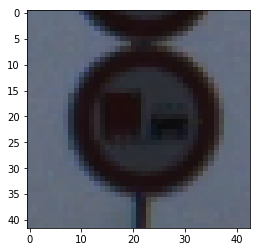

00920.ppm 12 Priority road


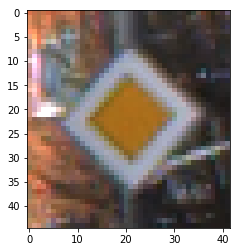

00314.ppm 1 Speed limit (30km/h)


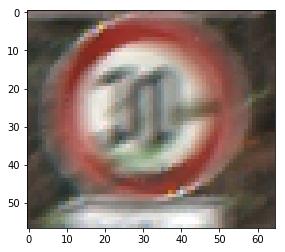

04816.ppm 25 Road work


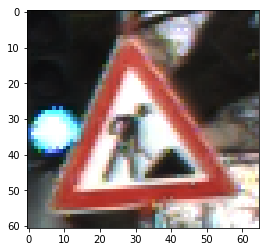

05959.ppm 5 Speed limit (80km/h)


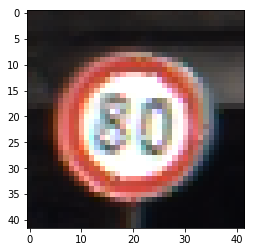

09102.ppm 1 Speed limit (30km/h)


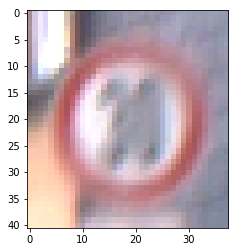

01541.ppm 29 Bicycles crossing


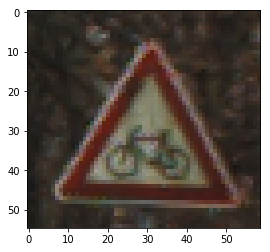

02728.ppm 15 No vechiles


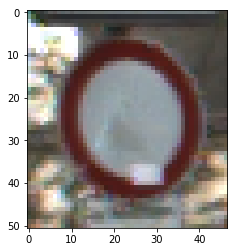

03602.ppm 2 Speed limit (50km/h)


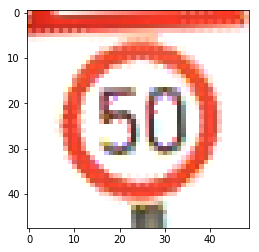

12548.ppm 9 No passing


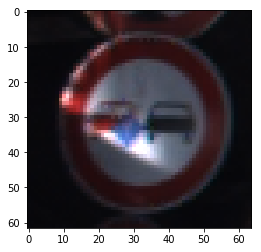

In [2697]:
for i in range(10):
    class_id = data.classes[pred_labels[i]]
    filename = data.test_ds.fnames[i].split('/')[1]
    print(filename, class_id, class_names[class_id])
    plt.imshow(load_img_id(data.test_ds, i, path))
    plt.show()

In [2698]:
with open('data/submission.csv', 'w') as f:
    for i in range(pred_labels.shape[0]):
        filename = data.test_ds.fnames[i].split('/')[1]
        f.write('{};{}\n'.format(filename, data.classes[pred_labels[i]]))

In [2699]:
from IPython.display import FileLink
FileLink('data/submission.csv')

/notebooks/sd/GTSRB/data/submission.csv